# Contrastive Mutual Information Estimation on EMG data

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import umap
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
sys.path.append('../')
from lift.datasets import get_mad_windows
from lift.utils import compute_features

seed = 0
eps = 1e-6

font_size = 14
strip_size = 12

plt.rc('font', size=font_size)            # controls default text sizes
plt.rc('axes', titlesize=font_size)       # fontsize of the axes title
plt.rc('axes', labelsize=strip_size)        # fontsize of the x and y labels
plt.rc('xtick', labelsize=strip_size)       # fontsize of the tick labels
plt.rc('ytick', labelsize=strip_size)       # fontsize of the tick labels
plt.rc('legend', fontsize=strip_size)       # legend fontsize

In [8]:
# aggregrate all female data
window_size = 200
window_increment = 50

features = [None] * 9
labels = [None] * 9
for i in range(9):
    data_path = f'../datasets/MyoArmbandDataset/PreTrainingDataset/Female{i}/training0/'
    windows, labels[i] = get_mad_windows(
        data_path, 
        window_size, 
        window_increment, 
        desired_labels=[0, 1, 2, 3, 4]
    )
    features[i] = compute_features(windows)

features = torch.cat(features, dim=0)
labels = torch.cat(labels, dim=0)

# normalize
x = features
x -= x.mean(dim=0)
x /= x.std(dim=0)

print(x.shape, labels.shape)

torch.Size([685, 32]) torch.Size([685])


In [10]:
# get embedding for 2d visualization
reducer = umap.UMAP(
    n_neighbors=50, 
    n_components=2, 
    metric="euclidean",
    n_jobs=1,
    random_state=0,
)
embeddings = reducer.fit_transform(x)

In [12]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.SiLU(inplace=True))
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            layers.append(nn.SiLU(inplace=True))
        layers.append(nn.Linear(hidden_dims[-1], output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
    
class Encoder(nn.Module):
    """Output a categorical distribution"""
    def __init__(self, input_dim, output_dim, hidden_dims, tau=0.5):
        super().__init__()
        self.mlp = MLP(input_dim, output_dim, hidden_dims)
        self.tau = tau
    
    def forward(self, x):
        p = torch.softmax(self.mlp(x), dim=-1)
        return p
    
    def sample(self, x):
        p = self.forward(x)
        z = F.gumbel_softmax(torch.log(p + 1e-6), tau=self.tau, hard=True)
        return z

In [13]:
def cross_entropy(p, q, eps=1e-6):
    logq = torch.log(q + eps)
    ce = -torch.sum(p * logq, dim=-1)
    return ce

def print_grads(model):
    for n, p in model.named_parameters():
        if p is None:
            print(n, None)
        else:
            print(n, p.grad.data.norm())

In [14]:
class NCE(nn.Module):
    def __init__(self, x_dim, z_dim, h_dim, hidden_dims, tau=0.5):
        super().__init__()
        self.encoder = Encoder(x_dim, z_dim, hidden_dims, tau=tau)
        self.critic_x = MLP(x_dim, h_dim, hidden_dims)
        self.critic_z = MLP(z_dim, h_dim, hidden_dims)

    def compute_loss(self, x, x_neg=None):
        z = self.encoder.sample(x)
        h_x = self.critic_x(x)
        h_z = self.critic_z(z)

        f = torch.einsum("ih, jh -> ij", h_z, h_x)
        p = torch.softmax(f, dim=-1)
        labels = torch.eye(len(h_x))
        loss = cross_entropy(labels, p)
        return loss.mean()
    
class TUBA(nn.Module):
    def __init__(self, x_dim, z_dim, h_dim, hidden_dims, tau=0.5):
        super().__init__()
        self.encoder = Encoder(x_dim, z_dim, hidden_dims, tau=tau)
        self.critic_x = MLP(x_dim, h_dim, hidden_dims)
        self.critic_z = MLP(z_dim, h_dim, hidden_dims)
        self.baseline = MLP(z_dim, 1, hidden_dims)

    def compute_loss(self, x, x_neg):
        z = self.encoder.sample(x)
        h_x_pos = self.critic_x(x)
        h_x_neg = self.critic_x(x_neg)
        h_z = self.critic_z(z)
        b_z = self.baseline(z)
        
        f_pos = torch.sum(h_x_pos * h_z, dim=-1, keepdim=True)
        f_neg = torch.sum(h_x_neg * h_z, dim=-1, keepdim=True)
        loss = f_pos - torch.exp(f_neg - b_z) - b_z + 1
        return -loss.mean()

In [31]:
def train(model, data, batch_size, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = []
    bar = tqdm(range(epochs))
    for e in bar:
        sample_idx_pos = torch.randint(len(data), size=(batch_size,))
        sample_idx_neg = torch.randint(len(data), size=(batch_size,))
        x_batch_pos = data[sample_idx_pos]
        x_batch_neg = data[sample_idx_neg]
        loss = model.compute_loss(x_batch_pos, x_batch_neg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bar.set_description(f"e: {e}, loss: {loss:.2f}")
        history.append(loss.data.item())
    return history

def plot_history(history):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(history)
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    plt.tight_layout()
    plt.show()

def plot_prediction(embeddings, z_pred, labels, s=4):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].scatter(embeddings[:, 0], embeddings[:, 1], c=z_pred.argmax(-1), s=s)
    ax[1].scatter(embeddings[:, 0], embeddings[:, 1], c=labels, s=4)

    ax[0].set_title("z")
    ax[1].set_title("label")
    plt.tight_layout()
    plt.show()

### InfoNCE loss

In [16]:
np.random.seed(0)
torch.manual_seed(0)

x_dim = x.shape[-1]
z_dim = 5
h_dim = 100 # feature dimension used to compute inner product energy function
hidden_dims = [200, 200, 200]
tau = 0.5
nce = NCE(x_dim, z_dim, h_dim, hidden_dims, tau)

batch_size = 200
lr = 3e-4
epochs = 3000
history = train(nce, x, batch_size, epochs, lr)

e: 2999, loss: 3.75: 100%|██████████| 3000/3000 [00:18<00:00, 163.08it/s]


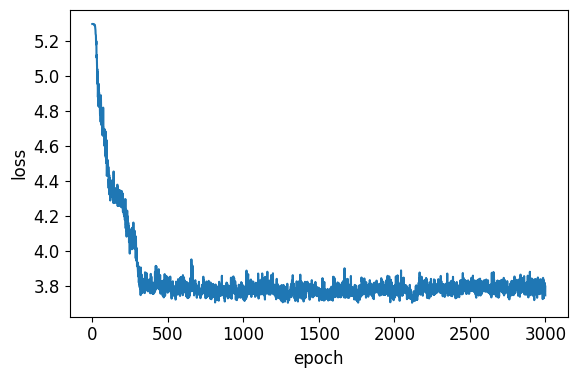

In [19]:
plot_history(history)

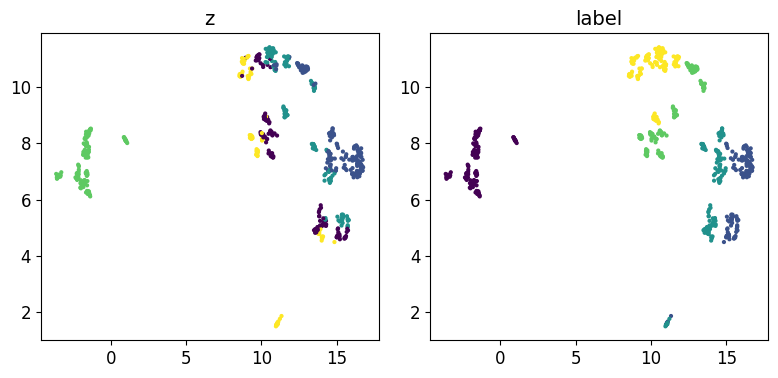

In [29]:
with torch.no_grad():
    z_nce = nce.encoder.sample(x)
plot_prediction(embeddings, z_nce, labels)

### TUBA loss

In [24]:
np.random.seed(0)
torch.manual_seed(0)

x_dim = x.shape[-1]
z_dim = 5
h_dim = 50 # feature dimension used to compute inner product energy function
hidden_dims = [200, 200, 200]
tau = 0.5
tuba = TUBA(x_dim, z_dim, h_dim, hidden_dims, tau)

batch_size = 300
lr = 3e-4
epochs = 3000
history = train(tuba, x, batch_size, epochs, lr)

e: 2999, loss: -1.42: 100%|██████████| 3000/3000 [00:27<00:00, 108.12it/s]


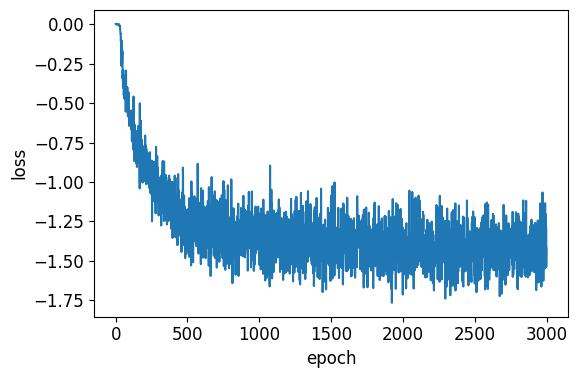

In [25]:
plot_history(history)

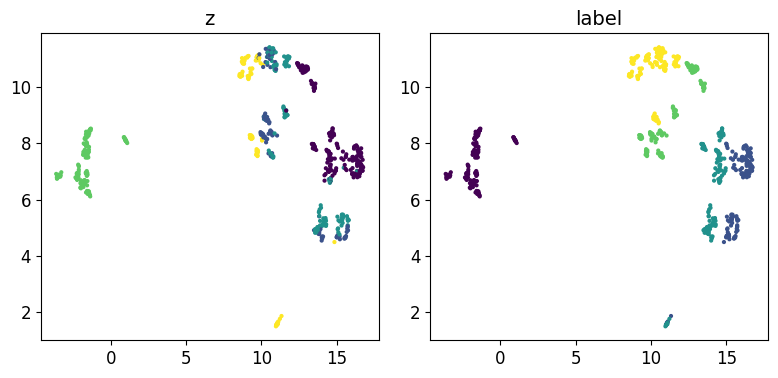

In [32]:
with torch.no_grad():
    z_tuba = tuba.encoder.sample(x)
plot_prediction(embeddings, z_tuba, labels)

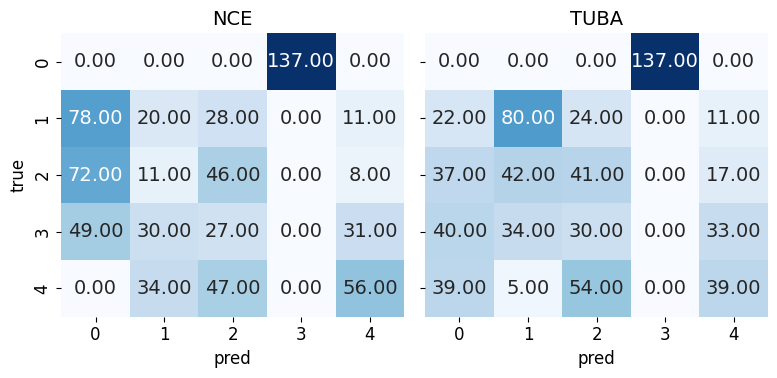

In [45]:
# compare nce and tuba
c_tuba = confusion_matrix(labels, z_tuba.argmax(-1))
c_nce = confusion_matrix(labels, z_nce.argmax(-1))

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
sns.heatmap(c_tuba, annot=True, cbar=False, fmt=".2f", cmap="Blues", ax=ax[0])
ax[0].set_xlabel("pred")
ax[0].set_ylabel("true")
ax[0].set_title("NCE")

sns.heatmap(c_nce, annot=True, cbar=False, fmt=".2f", cmap="Blues", ax=ax[1])
ax[1].set_xlabel("pred")
ax[1].set_title("TUBA")

plt.tight_layout()
plt.show()